This project aims to provide predictions of metwork activity a week ahead based on the past 4 months of data that was collected every 15 min. 

In [181]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)

Python version 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Pandas version 1.1.0


In [182]:
# Hard code the folder path and filenames. 

folder_path = "C:\\Users\\Xueho\\Projects\\Python Projects\\"
file_name = "per15minute_data_AP1.csv"

####  <b>Importing data and Exploratory data analysis

In [183]:
df = pd.read_csv(folder_path + file_name, index_col = [0], parse_dates=[0])
df.head(3)

,Time,y
0,5/2/2017 0:00,6365
1,5/2/2017 0:15,7580
2,5/2/2017 0:30,6286


In [184]:
# converting Time to datetime format

df['Time'] = df[['Time']].apply(pd.to_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11519 entries, 0 to 11518
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    11519 non-null  datetime64[ns]
 1   y       11519 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 270.0 KB


In [185]:
df1 = df.set_index('Time')
df1.head(3)

,y
Time,
2017-05-02 00:00:00,6365
2017-05-02 00:15:00,7580
2017-05-02 00:30:00,6286


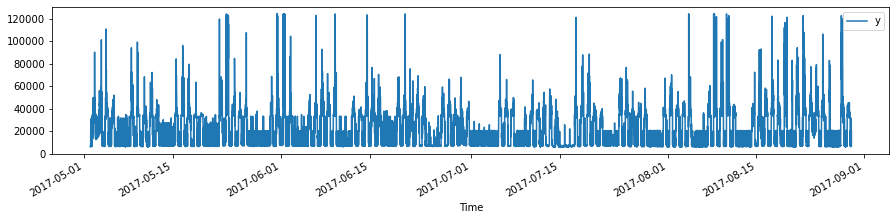

In [186]:
df1.plot(figsize=(15,3))

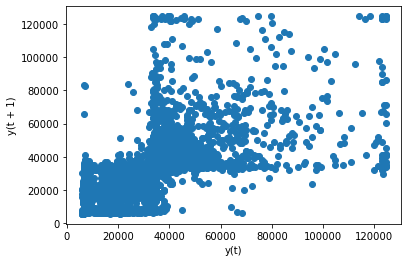

In [187]:
from pandas.plotting import lag_plot
lag_plot(df1.y)

In [188]:
# Calculating autocorrelation coefficient

values = pd.DataFrame(df1.values)
df2 = pd.concat([values.shift(1), values], axis=1)
df2.columns = ['t-1', 't+1']
result = df2.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.750915
t+1  0.750915  1.000000


There is an appearant autocorrelation within the data set.

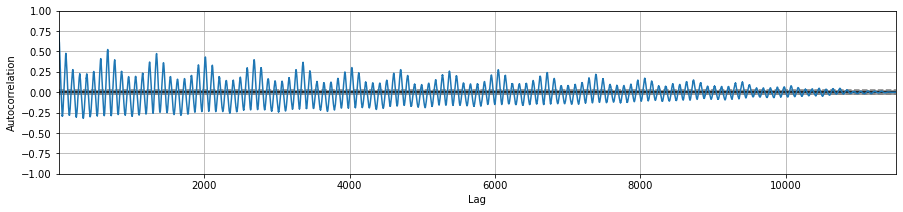

In [189]:
# plot correlation coefficient 

from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(15,3))
autocorrelation_plot(values)

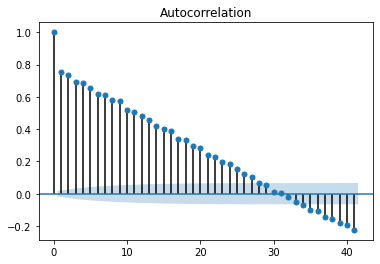

In [190]:
# plot Auto Correlation Function (acf)

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(values);

As indicated by the acf plots, the highest autocorrelation coefficient was found within about 4 lags with the coefficient above 0.7, which corresponds to one hour.  The coefficient decreases steadily and reverses to negative correlation after 30 lags.  

### Data decomposition 

Text(0, 0.5, 'residual')

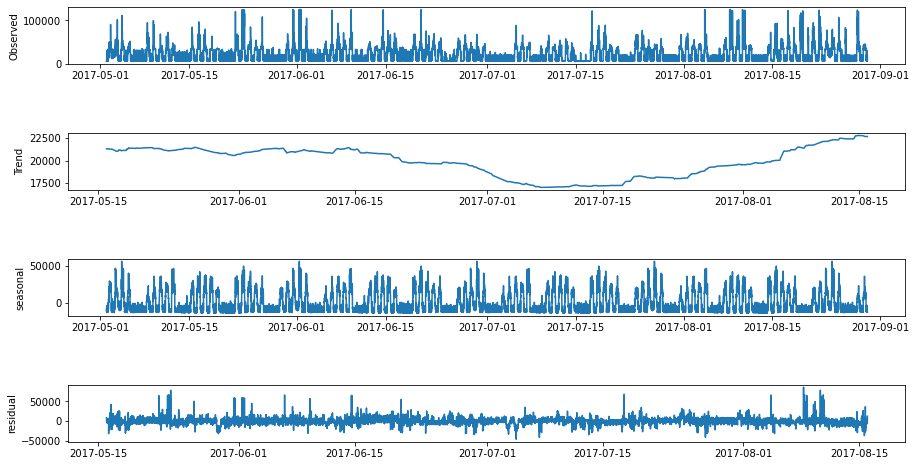

In [191]:
# Using stats model to find Trend, Seasonality and Noise in the data set
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df1, model='additive', period = 2688) # 4 points/hour, 96 point/day, 672/week, 2688/month

# Plot components with monthly trned
fig = plt.figure(figsize = (15,8))
fig.subplots_adjust(hspace=1.2, wspace=0.3)
ax1 = plt.subplot(4,1,1)
ax1.plot(decomposition.observed)
plt.ylabel('Observed')

ax2 = plt.subplot(4,1,2)
ax2.plot(decomposition.trend)
plt.ylabel('Trend')

ax3 = plt.subplot(4,1,3)
ax3.plot(decomposition.seasonal)
plt.ylabel('seasonal')

ax4 = plt.subplot(4,1,4)
ax4.plot(decomposition.resid)
plt.ylabel('residual')

Text(0, 0.5, 'residual')

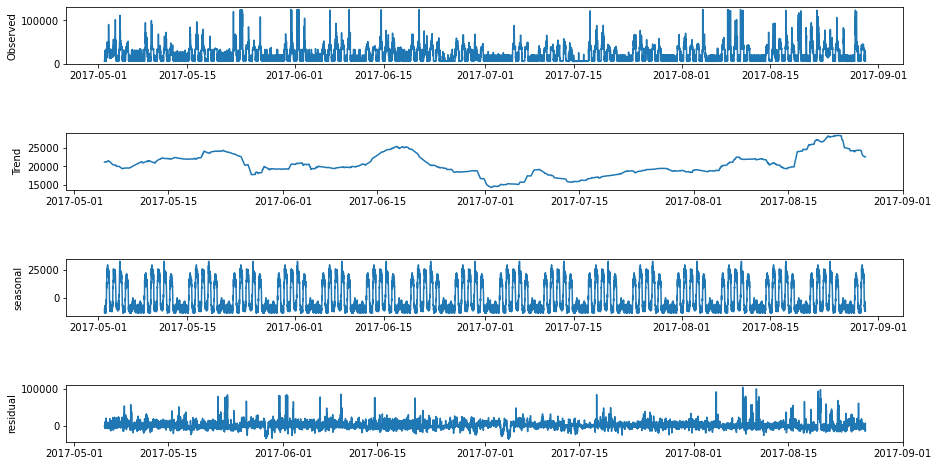

In [192]:
decomposition = seasonal_decompose(df1, model='additive', period = 672) # 4 points/hour, 96 point/day, 672/week, 2688/month

# Plot components with weekly trned
fig = plt.figure(figsize = (15,8))
fig.subplots_adjust(hspace=1.2, wspace=0.3)
ax1 = plt.subplot(4,1,1)
ax1.plot(decomposition.observed)
plt.ylabel('Observed')

ax2 = plt.subplot(4,1,2)
ax2.plot(decomposition.trend)
plt.ylabel('Trend')

ax3 = plt.subplot(4,1,3)
ax3.plot(decomposition.seasonal)
plt.ylabel('seasonal')

ax4 = plt.subplot(4,1,4)
ax4.plot(decomposition.resid)
plt.ylabel('residual')

The trends estimated based on monthly and weekly period both exhibited a decrease in activity near the month of July, consistent with the potential vacations people tend ot take during this time.  Next, I will use Fourier transformation to find the frequency components in the data.

Text(0, 0.5, 'power')

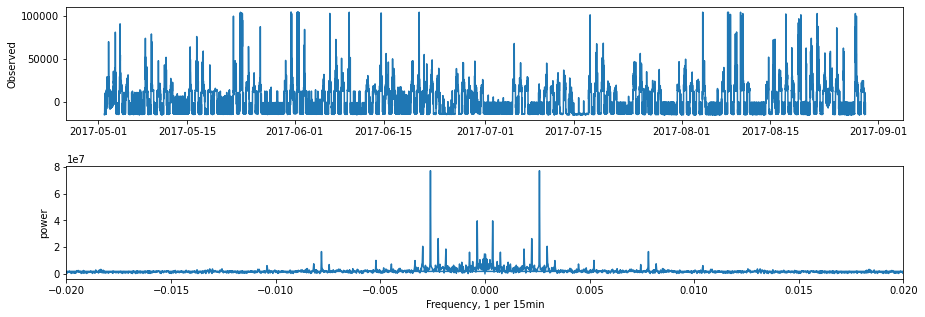

In [193]:
# Perform Fourier transform using scipy
from scipy import fftpack

y = np.array(df1.y)
y = y - np.mean(y) # remove dc components
y_fft = fftpack.fft(y)
power = np.abs(y_fft)
sample_freq = fftpack.fftfreq(df1.shape[0], d=4) #d = time step

# Plot data
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
ax1 = plt.subplot(2,1,1)
ax1.plot(df1.index, y)   # plot time series
plt.ylabel('Observed')

ax2 = plt.subplot(2,1,2)
ax2.plot(sample_freq, power)
ax2.set_xlabel('Frequency, 1 per 15min')
ax2.set_xlim(-0.02, 0.02)
ax2.set_ylabel('power')

In [194]:
# Find major frequencies for prominant freq components

pos_freq = sample_freq[sample_freq > 0] 
fp = [x for _, x in sorted(zip(power,pos_freq))][::-1][:5]

# calculating the main cycle of the signal: 1/freq
for f in fp:
    cycle = round(15/f/60, 0)
    print(f'cycle (number of points) = {cycle}'.format(cycle))

cycle (number of points) = 95.0
cycle (number of points) = 640.0
cycle (number of points) = 111.0
cycle (number of points) = 83.0
cycle (number of points) = 132.0


Recall the original data contains 4 points/hour, 96 point/day, 672/week, 2688/month.  The top two frequencies closely matching these two values, suggesting the daily and weekly cycles are the most prominent.

### <b>Forecast using fbprophet

In [195]:
# Preparing data set

df3 = df.copy()
df3.head(3)

,Time,y
0,2017-05-02 00:00:00,6365
1,2017-05-02 00:15:00,7580
2,2017-05-02 00:30:00,6286


In [196]:
df3.rename({'Time':'ds'}, axis=1, inplace=True)
df3.head(3)

,ds,y
0,2017-05-02 00:00:00,6365
1,2017-05-02 00:15:00,7580
2,2017-05-02 00:30:00,6286


In [197]:
# Use Box-Cox Transform y value to reduce noise

from scipy.stats import boxcox
df3['y'], lam = boxcox(df3['y'])
df3.head(3)

,ds,y
0,2017-05-02 00:00:00,2.651534
1,2017-05-02 00:15:00,2.658691
2,2017-05-02 00:30:00,2.651005


In [198]:
# split data to train and test data set
# Use test_size=0.06 reserves about one week worth of data

train = df3[: df3.shape[0]-672]
test = df3[: -672]

In [199]:
# Run fbprophet model with default parameters first

import pystan
from fbprophet import Prophet
m1 = Prophet() 
m1.fit(train)

# generates a week of predited data
future = m1.make_future_dataframe(freq = 'H', periods=24*7)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


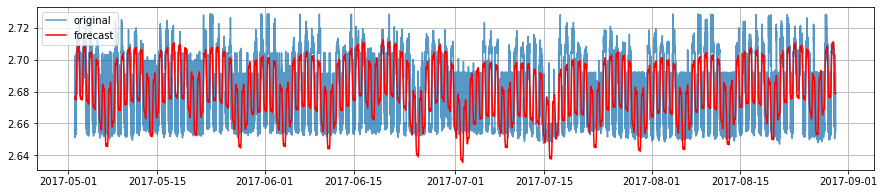

In [200]:
# Perform forecasting
forecast = m1.predict(future)

# visualize raw and predicted data
fig = plt.figure(figsize=(15,3))
plt.plot(df3.ds, df3.y, alpha=0.75)
plt.plot(forecast.ds, forecast.yhat, color='red')
plt.legend(('original', 'forecast'), loc='best')
plt.grid(True)

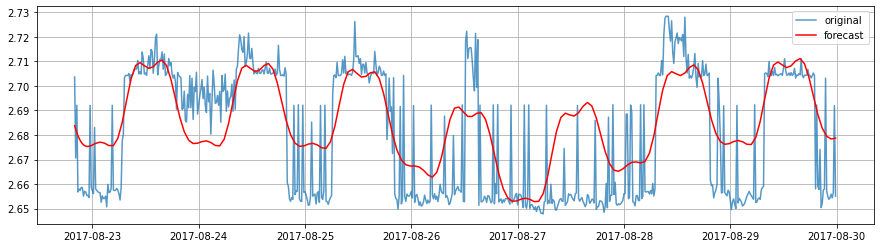

In [201]:
# Zoomed in towards the end of the data

fig = plt.figure(figsize=(15,4))
plt.plot(df3.ds[10831:], df3.y[10831:], alpha=0.75)
plt.plot(forecast.ds[10831:], forecast.yhat[10831:], color='red')
plt.legend(('original', 'forecast'), loc='best')
plt.grid(True)

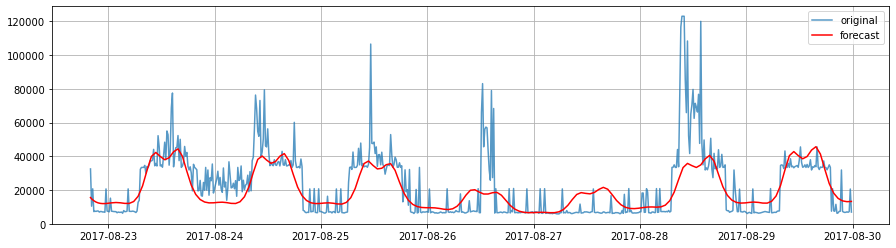

In [203]:
# Restore original data using inverse Box-Cox Transform
from scipy.special import inv_boxcox

df3.y = inv_boxcox(df3.y, lam)
forecast.yhat = inv_boxcox(forecast.yhat, lam)

fig = plt.figure(figsize=(15,4))
plt.plot(df3.ds[10831:], df3.y[10831:], alpha=0.75)
plt.plot(forecast.ds[10831:], forecast.yhat[10831:], color='red')
plt.legend(('original', 'forecast'), loc='best')
plt.grid(True)

In [206]:
train.tail(3)

,ds,y
10844,2017-08-22 23:15:00,6833.0
10845,2017-08-22 23:30:00,20654.0
10846,2017-08-22 23:45:00,7540.0


As seen above, the forcast capture the daily trend reasonably.  Note that the model was trained on data prior to 8/22/17.  The predicted results are plotted along with test data post 8/22/17.  

The activity on weekends are usually low, but on August 26th, which is a sat, there is a hige spike in web visits.  Checking back in history, according to "The Week", ten major random events happened that might trigger this activity that are impossible for the model to predict.  1. President Trump in Phoenix Tuesday all but promised clemency to Joe Arpaio, the former Arizona sheriff who was convicted in July of criminal contempt for defying an order to stop imprisoning suspected illegal immigrants.  2. Gorka ousted from White House post.  Sebastian Gorka is deputy assistant to the president.  3. Hurricane Harvey slows to Category 1 after land fall.  It was downgraded overnight from its Category 4 peak to Category 1 after making landfall in Texas late Friday.  4.Trump memo directs Pentagon to implement transgender troop ban.  5.North Korea tested three short-range missiles Saturday morning.  6.Sword-wielding man arrested outside Buckingham Palace.  7.U.S. military helicopter crashes near Yemen. 8. Kasich, Hickenlooper reportedly mull bipartisan 2020 challenge to Trump. <b>9.Mayweather-McGregor fight looks to break betting records. The highly anticipated boxing match between Floyd Mayweather and Conor McGregor takes place Saturday night at 9 p.m. ET in Las Vegas. 10. Taylor Swift released her first single in three years, titled "Look What You Made Me Do," late Thursday night. </b>  The last two events are entertainment in nature and are the mostly likely factor to trigger an increase in web visit.

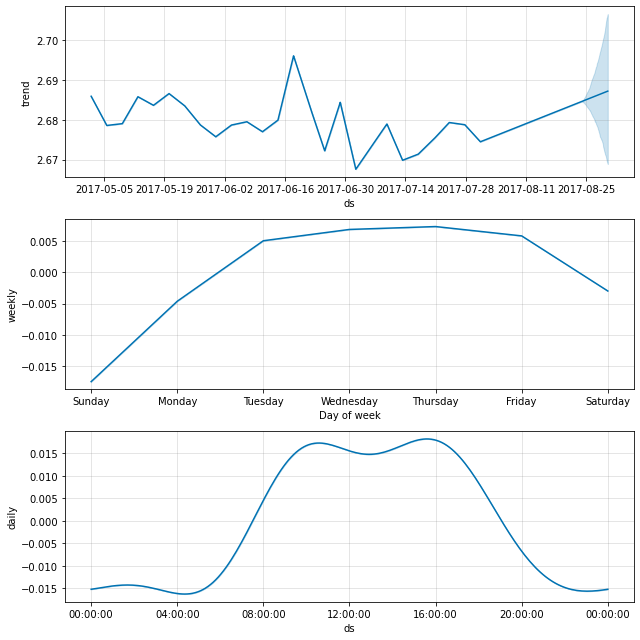

In [160]:
# Visualize the individual forecast components

m1.plot_components(forecast);

Both statsmodel and fbprophet were able to estimate the daily and weekly cyclic nature of the data.  both also detected teh drop in acitivity in the month of July, consistent vacation times.